<a href="https://colab.research.google.com/github/ampnb/ChronicStressProject/blob/main/EEG_Stress_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [2]:
!gdown --id 1KZjrJfUrB_k1g8VUsohNpek_hvWNqGcr

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:125: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1KZjrJfUrB_k1g8VUsohNpek_hvWNqGcr
To: /content/Clean_signal.zip
100% 113M/113M [00:00<00:00, 162MB/s]


In [3]:
!unzip '/content/Clean_signal.zip'
#!mv '/content/clean_exp16' 'Cleaned_signal'

Archive:  /content/Clean_signal.zip
   creating: Clean_signal/
  inflating: __MACOSX/._Clean_signal  
  inflating: Clean_signal/PSS10 - Sheet1.csv  
  inflating: __MACOSX/Clean_signal/._PSS10 - Sheet1.csv  
  inflating: Clean_signal/clean_exp08.csv  
  inflating: __MACOSX/Clean_signal/._clean_exp08.csv  
  inflating: Clean_signal/clean_exp09.csv  
  inflating: __MACOSX/Clean_signal/._clean_exp09.csv  
  inflating: Clean_signal/clean_exp01.csv  
  inflating: __MACOSX/Clean_signal/._clean_exp01.csv  
  inflating: Clean_signal/clean_exp15.csv  
  inflating: __MACOSX/Clean_signal/._clean_exp15.csv  
  inflating: Clean_signal/clean_exp14.csv  
  inflating: __MACOSX/Clean_signal/._clean_exp14.csv  
  inflating: Clean_signal/clean_exp16.csv  
  inflating: __MACOSX/Clean_signal/._clean_exp16.csv  
  inflating: Clean_signal/clean_exp02.csv  
  inflating: __MACOSX/Clean_signal/._clean_exp02.csv  
  inflating: Clean_signal/clean_exp03.csv  
  inflating: __MACOSX/Clean_signal/._clean_exp03.csv  
 

In [6]:
pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 5.9 MB/s 


In [7]:
pip install components

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import pickle
import numpy as np
import os
import mne
import pandas as pd
pickle.format_version

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms  
from torch.utils.data import DataLoader, Dataset  
from torch.utils.data import TensorDataset
from torch.autograd import Variable

import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# setting seed so that splitting process and training process can be reproduce
torch.manual_seed(1)

# ETL

In [9]:
import os
main_path = os.getcwd()
filename = os.listdir(main_path + '/Clean_signal/')

In [10]:
filename = ['clean_exp01.csv',
 'clean_exp02.csv',
 'clean_exp03.csv',
 'clean_exp04.csv',
 'clean_exp05.csv',
 'clean_exp06.csv',
 'clean_exp07.csv',
 'clean_exp08.csv',
 'clean_exp09.csv',
 'clean_exp10.csv',
 'clean_exp11.csv',
 'clean_exp12.csv',
 'clean_exp13.csv',
 'clean_exp14.csv',
 'clean_exp15.csv',
 'clean_exp16.csv',
 'clean_exp17.csv']

In [11]:
all_file_path = main_path + '/Clean_signal/'
X_list = list()
for file in filename:
    file_path = all_file_path + file
    df = pd.read_csv(file_path, index_col=None)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    X_list.append(df)  

In [12]:
df.head()

,Fp1,Fp2,F7,F3,F4,F8,T3,C3,C4,T4,T5,P3,P4,T6,O1,O2
0,1.558541e-13,1.202787e-12,-1.822815e-12,-6.666149e-13,-1.524659e-14,-9.656176e-14,1.778769e-13,-7.318365e-13,-3.218725e-14,6.776264e-15,2.463172e-12,-5.293956e-13,1.679243e-13,2.774456e-12,-3.303428e-13,2.217109e-13
1,-2.495299e+02,-2.591266e+02,-2.392414e+02,-2.472481e+02,-1.342918e+02,-2.469675e+02,-2.368676e+02,-2.375381e+02,8.964020e+01,9.114929e+01,9.105020e+01,7.684951e+01,1.383037e+02,-4.155527e+02,-3.083336e+02,-1.145710e+02
2,-1.022146e+02,-1.071695e+02,-8.913196e+01,-9.320015e+01,-7.188064e+01,-9.669399e+01,-7.360927e+01,-7.934479e+01,-8.483305e+00,-3.966042e+00,6.921319e-02,-5.860820e+00,6.340924e+00,-1.006591e+02,-7.385641e+01,-3.186257e+01
3,-1.894707e+02,-1.985657e+02,-1.666088e+02,-1.773347e+02,-1.206077e+02,-1.861381e+02,-1.566157e+02,-1.616160e+02,1.053098e+01,1.359837e+01,2.570865e+01,1.375228e+01,4.319836e+01,-2.383818e+02,-1.751361e+02,-7.472951e+01
4,-1.976600e+02,-2.088452e+02,-1.691085e+02,-1.829386e+02,-1.219805e+02,-1.981792e+02,-1.664133e+02,-1.711082e+02,5.430791e+00,5.540176e+00,2.039321e+01,9.522058e+00,4.153111e+01,-2.713544e+02,-1.985949e+02,-9.082392e+01


In [13]:
X = np.array(X_list)
X.shape 
#17 people 
#250 hz * 60 secs * 3 min
#16 channels

(17, 45000, 16)

In [14]:
# Reshape
X = np.transpose(X, (0, 2, 1))
X.shape

(17, 16, 45000)

In [15]:
def vectorized_windowing(arr, window_len, overlap_len=None):
    '''
    Sliding window without using loop
    '''
    seq_len = arr.shape[-1]
    
    if not overlap_len:
        overlap_len = window_len

    n_sliding_windows = ((seq_len - window_len) // overlap_len) + 1

    sub_windows = np.array([np.arange(window_len)]) + np.array([np.arange(n_sliding_windows) * overlap_len]).T

    slided_arr = arr[..., sub_windows]

    return slided_arr


In [71]:
X_chunked = vectorized_windowing(X, window_len=4500)
X_chunked = np.swapaxes(X_chunked,1,2).reshape(-1, 16, 4500)

print(X_chunked.shape)

X = X_chunked.copy()

# 17 people split in 10 chunks
# 16 channels
# 4500 signals 

(170, 16, 4500)


In [72]:
y_path = '/content/Clean_signal/PSS10 - Sheet1.csv'
df = pd.read_csv(y_path)
y = np.array(df['label'])
y

array([1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1])

In [73]:
y_chunked = np.repeat(y, 10)

y = y_chunked.copy()

In [74]:
y_chunked.shape

(170,)

# Split Data

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = False, stratify = None)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(136, 16, 4500) (34, 16, 4500) (136,) (34,)


In [76]:
print(X_test)

[[[ 7.84200330e+00  1.47207470e+01  1.42052595e+01 ... -5.89349247e+00
   -1.51828042e+01 -2.08104358e+01]
  [ 3.16583543e+00  8.26135009e+00  9.23106733e+00 ... -2.71454574e+01
   -3.25662288e+01 -3.54135998e+01]
  [ 2.32398500e+00  5.09731303e+00  3.61993697e-01 ... -1.74988647e+01
   -2.87856476e+01 -3.47425425e+01]
  ...
  [-8.76076464e+00 -1.74142656e+00  5.77302593e-01 ...  2.39540520e+00
    2.14318766e+00 -1.96665306e+00]
  [ 3.02666012e+00  6.51500100e+00  4.10581095e+00 ...  3.91447209e+01
    3.74479023e+01  2.25009333e+01]
  [-1.46662092e+01 -3.50361569e+00  1.18964341e+00 ...  1.17311595e+01
    1.10058886e+01 -3.73502614e+00]]

 [[-1.82454441e+01 -1.57154517e+01 -9.08109711e+00 ... -5.01454830e+00
   -8.80962712e+00 -4.94259629e+00]
  [-3.47973429e+01 -3.61339346e+01 -2.94382432e+01 ... -2.55171581e+00
   -7.39142312e+00 -5.25420300e+00]
  [-3.00576255e+01 -3.15323330e+01 -2.53430851e+01 ...  2.28278037e+00
   -2.40692220e+00 -6.11756015e-02]
  ...
  [-2.07971800e+00 -2.5

In [77]:
print(X_test)

[[[ 7.84200330e+00  1.47207470e+01  1.42052595e+01 ... -5.89349247e+00
   -1.51828042e+01 -2.08104358e+01]
  [ 3.16583543e+00  8.26135009e+00  9.23106733e+00 ... -2.71454574e+01
   -3.25662288e+01 -3.54135998e+01]
  [ 2.32398500e+00  5.09731303e+00  3.61993697e-01 ... -1.74988647e+01
   -2.87856476e+01 -3.47425425e+01]
  ...
  [-8.76076464e+00 -1.74142656e+00  5.77302593e-01 ...  2.39540520e+00
    2.14318766e+00 -1.96665306e+00]
  [ 3.02666012e+00  6.51500100e+00  4.10581095e+00 ...  3.91447209e+01
    3.74479023e+01  2.25009333e+01]
  [-1.46662092e+01 -3.50361569e+00  1.18964341e+00 ...  1.17311595e+01
    1.10058886e+01 -3.73502614e+00]]

 [[-1.82454441e+01 -1.57154517e+01 -9.08109711e+00 ... -5.01454830e+00
   -8.80962712e+00 -4.94259629e+00]
  [-3.47973429e+01 -3.61339346e+01 -2.94382432e+01 ... -2.55171581e+00
   -7.39142312e+00 -5.25420300e+00]
  [-3.00576255e+01 -3.15323330e+01 -2.53430851e+01 ...  2.28278037e+00
   -2.40692220e+00 -6.11756015e-02]
  ...
  [-2.07971800e+00 -2.5

In [78]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=999)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(122, 16, 4500) (14, 16, 4500) (122,) (14,)


In [79]:
from sklearn.preprocessing import MinMaxScaler

#scale transform each channel independently
scalers = {}
for i in range(X_train.shape[2]):
    scalers[i] = MinMaxScaler(feature_range=(-1, 1))
    X_train[:, :, i] = scalers[i].fit_transform(X_train[:, :, i]) 

for i in range(X_val.shape[2]):
    X_val[:, :, i]   = scalers[i].transform(X_val[:, :, i])     
    
for i in range(X_test.shape[2]):
    X_test[:, :, i]  = scalers[i].transform(X_test[:, :, i]) 

In [80]:
print(X_train.mean(), X_val.mean(), X_test.mean())
print(X_train.min(), X_val.min(), X_test.min())
print(X_train.max(), X_val.max(), X_test.max())

0.004228958769664231 0.004157039756496878 0.004641125739653987
-1.0 -29.253222821649473 -257.7915643965592
1.0000000000000004 15.788878605040534 870.0946728954643


# Define Batch size and train,test, val loader

In [81]:
X_train_tensor = torch.tensor(X_train).to(torch.float32)
y_train_tensor = torch.tensor(y_train).to(torch.float32)
X_val_tensor = torch.tensor(X_val).to(torch.float32)
y_val_tensor = torch.tensor(y_val).to(torch.float32)
X_test_tensor = torch.tensor(X_test).to(torch.float32)
y_test_tensor = torch.tensor(y_test).to(torch.float32)

# Cast data to dataloader for more convenience
training_set = TensorDataset(X_train_tensor, y_train_tensor)
testing_set = TensorDataset(X_test_tensor, y_test_tensor)
validation_set = TensorDataset(X_val_tensor, y_val_tensor)

train_batch_size = 32
val_batch_size = len(validation_set)
test_batch_size = len(testing_set)

train_loader = DataLoader(training_set, train_batch_size, shuffle=True)
val_loader = DataLoader(validation_set, val_batch_size, shuffle=True)
test_loader = DataLoader(testing_set, test_batch_size, shuffle=True)

In [82]:
for data, label in train_loader:
  print(data)
  break

tensor([[[ 0.4009, -0.4025, -0.1494,  ..., -0.0950, -0.7196,  0.1631],
         [ 0.3356,  0.8194,  0.4492,  ...,  0.6008,  0.8193,  0.4361],
         [ 0.2170, -0.4353, -0.1286,  ..., -0.6672, -1.0000, -0.0748],
         ...,
         [ 0.4583, -0.6802, -0.1381,  ...,  0.7840,  0.2209,  0.6766],
         [ 0.7633,  0.7314,  0.7361,  ...,  0.7080,  0.7432,  0.7674],
         [ 0.7411,  0.6117, -0.0446,  ...,  0.9558,  0.8781,  0.7777]],

        [[ 0.3373, -0.5012, -0.2741,  ...,  0.2261,  0.3842,  0.1631],
         [ 0.3523,  0.8157,  0.4216,  ...,  0.6823,  0.9234,  0.4361],
         [ 0.2666, -0.4215, -0.1113,  ..., -0.3478,  0.0447, -0.0748],
         ...,
         [ 0.4747, -0.6412, -0.0534,  ...,  0.8008,  0.2178,  0.6766],
         [ 0.7755,  0.7516,  0.7571,  ...,  0.7114,  0.7493,  0.7674],
         [ 0.7532,  0.6523, -0.0216,  ...,  0.9567,  0.8787,  0.7777]],

        [[ 0.3030, -0.4288, -0.1108,  ..., -0.1985, -0.4254, -0.1813],
         [ 0.2413,  0.8103,  0.4532,  ...,  0

In [83]:
data.shape

torch.Size([32, 16, 4500])

In [84]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# CNN1D model

In [85]:
class eegConv1d(nn.Module):
    def __init__(self, input_size = 16, out_size=2):
        super().__init__()
        self.c1 = nn.Conv1d(input_size, 50, kernel_size = 3)
        self.c2 = nn.Conv1d(50, 30, kernel_size = 3)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.maxpool1d = nn.MaxPool1d(2,2)
        self.linear = nn.Linear(30 * 2247, out_size) #taking the last hidden state
        
    def forward(self, seq):
        #convo layer 8 -> 50 -> 30
        #seq shape: (11, 50, 45000)
        out = self.c1(seq)
        out = self.relu(out)
        out = self.dropout(out)
        # out shape: (11, 50, 44998)
        out = self.maxpool1d(out)
        # out shape: (11, 50, 22499)
        out = self.c2(out)
        out = self.relu(out)
        # out shape: (11, 30, 22496)
        out = out.reshape(seq.size(0), -1)
        #out shape: (30, 30*22496)
        out = self.linear(out)
        #out shape: (30*22496, 2)
        return out

In [97]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [98]:
# torch.manual_seed(999999)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = eegConv1d(input_size=16).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [99]:
epochs = 200

best_valid_loss = float('inf')
model.train()

train_losses = []
train_accs   = []
valid_losses = []
valid_accs   = []


#print(f"Training {type(model).__name__}")

for i in range(epochs):
    train_total = 0
    train_correct = 0
    val_total   = 0  
    val_correct = 0
    train_acc   = 0
    val_acc     = 0
    
    for X_train, y_train in train_loader:
    
        start_time = time.time()
        
        X_train = X_train.float().to(device)
        y_train = y_train.type(torch.LongTensor).to(device)

        #print(X_train.shape, X_train.dtype)

        yhat_train = model(X_train)
        
        #train acc
        _, predicted = torch.max(yhat_train.data, 1)  #returns max value, indices
        train_total += y_train.size(0)  #keep track of total
        train_correct += (predicted == y_train).sum().item()  #.item() give the raw number
        train_acc = 100 * (train_correct / train_total)
        
        #print(y_train.shape, y_train.dtype)
        
        train_loss = criterion(yhat_train, y_train)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        end_time = time.time()
    

        #val accuracy
        for X_val, y_val in val_loader:
            X_val = X_val.float().to(device)
            y_val = y_val.type(torch.LongTensor).to(device)
            yhat_val  = model(X_val)
            val_loss     = criterion(yhat_val, y_val)
            _, predicted = torch.max(yhat_val.data, 1)  #returns max value, indices
            val_total += y_val.size(0)  #keep track of total
            val_correct += (predicted == y_val).sum().item()  #.item() give the raw number
            val_acc = 100 * (val_correct / val_total)

        #save the best model
        if  val_loss < best_valid_loss:
            best_valid_loss = val_loss
            #print("Model:{} saved.".format(type(model).__name__))
            torch.save(model.state_dict(), './models/CNN1D.pt')
            best_model_index = i

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)


                    #for plotting
        train_losses.append(train_loss.item())
        train_accs  .append(train_acc)
        valid_losses.append(val_loss.item())
        valid_accs  .append(val_acc)

    print(f"Epoch: {i:2.0f} | Train acc: {train_acc: 2.2f} | " +
          f"loss: {train_loss:2.5f} | Val acc: {val_acc: 2.2f} | " +
          f"loss: {val_loss:2.5f} | Time: {epoch_mins}m {epoch_secs}s")

Epoch:  0 | Train acc:  62.30 | loss: 0.67652 | Val acc:  57.14 | loss: 0.70248 | Time: 0m 0s
Epoch:  1 | Train acc:  56.56 | loss: 0.68236 | Val acc:  50.00 | loss: 0.80297 | Time: 0m 0s
Epoch:  2 | Train acc:  63.93 | loss: 0.56509 | Val acc:  57.14 | loss: 0.76120 | Time: 0m 0s
Epoch:  3 | Train acc:  67.21 | loss: 0.59906 | Val acc:  55.36 | loss: 0.71392 | Time: 0m 0s
Epoch:  4 | Train acc:  64.75 | loss: 0.64155 | Val acc:  57.14 | loss: 0.81181 | Time: 0m 0s
Epoch:  5 | Train acc:  65.57 | loss: 0.52618 | Val acc:  57.14 | loss: 0.71430 | Time: 0m 0s
Epoch:  6 | Train acc:  68.85 | loss: 0.62027 | Val acc:  57.14 | loss: 0.72324 | Time: 0m 0s
Epoch:  7 | Train acc:  69.67 | loss: 0.55094 | Val acc:  57.14 | loss: 0.74590 | Time: 0m 0s
Epoch:  8 | Train acc:  68.85 | loss: 0.57148 | Val acc:  57.14 | loss: 0.71190 | Time: 0m 0s
Epoch:  9 | Train acc:  69.67 | loss: 0.61264 | Val acc:  57.14 | loss: 0.73783 | Time: 0m 0s
Epoch: 10 | Train acc:  69.67 | loss: 0.64221 | Val acc:  57

In [100]:
y_train.shape

torch.Size([26])

In [101]:
yhat = model(X_test_tensor.float().to(device))
#testloss = criterion(yhat, y_test_tensor.type(torch.LongTensor).to(device))
_, predicted = torch.max(yhat.data, 1)

predicted

tensor([0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

Text(0, 0.5, 'loss')

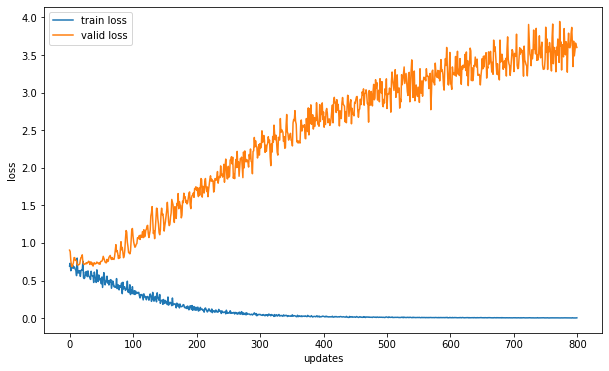

In [102]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax  = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [113]:
#train_losses

Text(0, 0.5, 'acc')

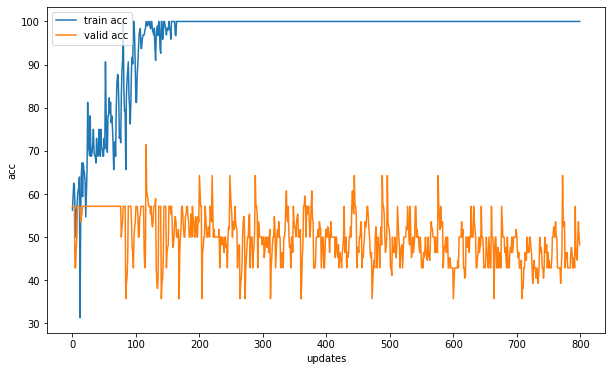

In [104]:
fig = plt.figure(figsize=(10, 6))
ax  = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')